# Notch Filter Design overview

#### Last Updated: 
November 15th 2020
##### Written by:
Ryan Kari

##### Overview
The following provides an overview of the filter design procedure as described ["Linear Circuit Design Handbook"](https://www.analog.com/en/education/education-library/linear-circuit-design-handbook.html), Edited by Hank Zumbahlen, Published by Newnes/Elsevier, 2008, ISBN-978-0-7506-8703-4, focused on designing a notch filter. In particular, [Chapter 8](https://www.analog.com/media/en/training-seminars/design-handbooks/Basic-Linear-Design/Chapter8.pdf).  

The method described begins by choosing a low-pass filter response, and then transforming it into a different type of response such as high-pass, pass-band, or notch-filter. The results of the transformation are frequencies and quality factors (alternatively described as damping ratios) of each stage. This can also be represented as poles and zeros in a controls setting. The filter configuration can then be implemented with a number of different filter topologies such as: twin-T, Boctor, Bainter, etc., by applying equations that allow the component values to be chosen based on the frequencies and quality factors required for each stage.  The following document is only focused on a notch filter implemented with a Bainter topology.

It should be noted that op-amp limitations are not taken into account. It's generally best practice to simulate the filter response with a circuit simulator, such as P-Spice, Circuitlab.com, LT-Spice, etc. Depending upon the op-amp, it will be noted that the peak demand for gain bandwidth product occurs close to the notch frequency and should be carefully inspected. Insufficient gain bandwidth product and slew rate will result in the frequencies and damping of each stage shifting, such that the misalignment of each stage will result in the combination of all stages not behaving as expected. It has been noted that by rule-of-thumb, best performance requires op-amps that provide a margin of more than 50 times that of the calculated gain-bandwidth product.  

# 1. Theory using low-pass to filter transformation

The following is copied out of the Linear Circuit Design Handbook cited above for reference:

As in the band-pass case, a band-reject filter can be either wideband or narrow-band,
depending on whether or not the poles are separated by 2 octaves or more. To avoid
confusion, the following convention will be adopted. If the filter is wideband, it will be
referred to as a band-reject filter. A narrow-band filter will be referred to as a notch filter.
One way to build a notch filter is to construct it as a band-pass filter whose output is
subtracted from the input (1 – BP). Another way is with cascaded low-pass and high-pass
sections, especially for the band-reject (wideband) case. In this case, the sections are in
parallel, and the output is the difference.
Just as the band-pass case is a direct transformation of the low-pass prototype, where dc
is transformed to F0, the notch filter can be first transformed to the high-pass case, and
then dc, which is now a zero, is transformed to F0.
A more general approach would be to convert the poles directly. A notch transformation
results in two pairs of complex poles and a pair of second order imaginary zeros from
each low-pass pole pair.
First, the value of QBR is determined by:
    $ Q_{br} = \frac{F_o}{BW}$ Eq. 8-67
    
where BW is the bandwidth at -3dB.

Given the pole locations of the low-pass prototype:

-α ± jβ Eq. 8-68

and the values of $F_0$ and $Q_{BR}$, the following calculations will result in two sets of values
for Q and frequencies, $F_H$ and $F_L$, which define a pair of notch filter sections. The transformation equations are given in Eq. 8-69 to 8-82



In [1]:
from IPython.display import display
from scipy import signal
import sympy as sy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from Filter_Definitions import Filter_Definitions

# 2.Import different filter types
This could likely be ported from an existing python library. The function called is a copy of the filter design tables from the Linear Circuit Design Handbook. Not all filter definitions are included, nor do I focus on elliptical implementations as I tend to require minimal deviation in the pass-bands (not an attribute of elliptical filters). 

In [2]:
df = Filter_Definitions()
display(HTML(df.to_html()))

,Type,Order,Section,Real Part,Imaginary Part,Fo,alpha,Q,-3dB Frequency,Peaking Frequency,Peaking Level
0,Butterworth,2,1,0.7071,0.7071,1.0000,1.4142,0.7071,1.0000,NaN,NaN
1,Butterworth,3,1,0.5000,0.8660,1.0000,1.0000,1.0000,NaN,0.7071,1.2493
2,Butterworth,3,2,1.0000,NaN,1.0000,NaN,NaN,1.0000,NaN,NaN
3,Butterworth,4,1,0.9239,0.3827,1.0000,1.8478,0.5412,0.7195,NaN,NaN
4,Butterworth,4,2,0.3827,0.9239,1.0000,0.7654,1.3065,NaN,0.8409,3.0102
5,Butterworth,5,1,0.8090,0.5878,1.0000,1.6180,0.6180,0.8588,NaN,NaN
6,Butterworth,5,2,0.3090,0.9511,1.0000,0.6180,1.6182,NaN,0.8995,4.6163
7,Butterworth,5,3,1.0000,NaN,1.0000,NaN,NaN,NaN,NaN,NaN
8,Butterworth,6,1,0.9659,0.2588,1.0000,1.9319,0.5176,0.6758,NaN,NaN
9,Butterworth,6,2,0.7071,0.7071,1.0000,1.4142,0.7071,1.0000,NaN,NaN


In [3]:
print("The following filter definitions are available:")
types_available = df.groupby('Type')
for item in types_available.groups.keys():
    print(item)


The following filter definitions are available:
0.1dB Chebyshev
0.5dB Chebyshev
1.0dB Chebyshev
Butterworth


# 3. Define filter characteristics of interest 

In [4]:
filtertype = '0.5dB Chebyshev'
low_pass_filter_order = 3

# Center frequency of notch in Hz
Fcenter = 33800
BW = 4000 # Defines distance from -3dB to center, such that the smaller, the sharper

df_selected = df.loc[(df['Type'] == filtertype ) & (df['Order'] == low_pass_filter_order)]
number_stages = df_selected.shape[0]
display(HTML(df_selected.to_html()))

,Type,Order,Section,Real Part,Imaginary Part,Fo,alpha,Q,-3dB Frequency,Peaking Frequency,Peaking Level
1,0.5dB Chebyshev,3,1,0.2683,0.8753,1.0688,0.5861,1.7061,NaN,0.9727,5.0301
2,0.5dB Chebyshev,3,2,0.5366,NaN,0.6265,NaN,NaN,0.6265,NaN,NaN


# 4. Filter transformation
Defines frequencies to be used for each filter stage

In [5]:
column_names = ['Qbr','Fstage','Qstage']
df_transform = pd.DataFrame(columns=column_names)

is_odd_order = low_pass_filter_order%2

# For each section, calculate characteristics for filter stage
# If filter order is odd, last section is represented by the transformation of a single pole
# This will be centered at Fo with Q defined by the section
for index,section in enumerate(df_selected.iterrows()):
    index=index+1
    print('index = ',index,'number of stages = ',number_stages)
    Qbr = Fcenter/BW
    C = section[1]['Real Part']**2 + section[1]['Imaginary Part']**2
    D = section[1]['Real Part']/(Qbr*C)
    E = section[1]['Imaginary Part']/(Qbr*C)
    F = E**2-D**2+4
    G = np.sqrt(F/2+ np.sqrt(F**2/4)) + D**2 * E**2
    H = D*E/G
    K = 1/2*np.sqrt((D+H)**2+(E+G)**2)
    Q = K/(D+H)
    
    # If section being considered is less than number of stages and filter even
    if ((index<number_stages)):
        Fbr1 = Fcenter/K
        Fbr2 = Fcenter*K
        Qbr1 = Q
        Qbr2 = Q
        Fbr3 = np.nan
        Qbr3 = np.nan         
        temp = pd.DataFrame({'Qbr':[Qbr,Qbr],'Fstage':[Fbr1,Fbr2],'Qstage':[Qbr1,Qbr2]})
        df_transform = pd.concat([df_transform,temp])
    # If considering the final stage need to handle differently if odd or even     
    if (index==number_stages):
        if is_odd_order:
            Fbr3 = Fcenter
            Qbr3 = Qbr*section[1]['Real Part']
            temp = pd.DataFrame({'Qbr':[Qbr],'Fstage':[Fbr3],'Qstage':[Qbr3]})
            df_transform = pd.concat([df_transform,temp])
        else:
            Fbr1 = Fcenter/K
            Fbr2 = Fcenter*K
            Qbr1 = Q
            Qbr2 = Q   
            temp = pd.DataFrame({'Qbr':[Qbr,Qbr],'Fstage':[Fbr1,Fbr2],'Qstage':[Qbr1,Qbr2]})
            df_transform = pd.concat([df_transform,temp])
            
df_transform = df_transform.reset_index(drop=True)

display(HTML(df_transform.to_html()))

index =  1 number of stages =  2
index =  2 number of stages =  2


,Qbr,Fstage,Qstage
0,8.45,31775.131698,26.447364
1,8.45,35953.902909,26.447364
2,8.45,33800.000000,4.534270


# 5. Use filter characteristics to generic component values for each stage
The following is again copied from the Linear Circuit Design Handbook for reference:

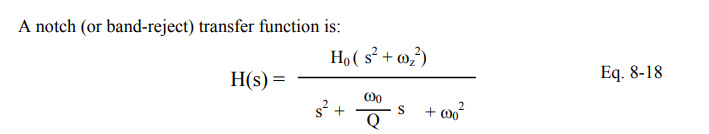

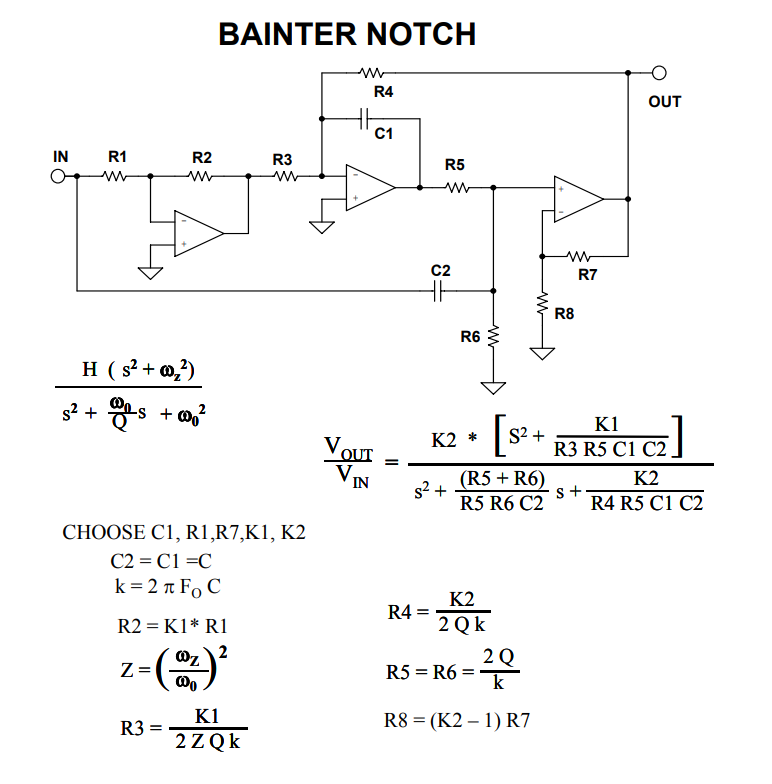

### Define 1st filter stage choosing frequency and capacitor values for C1 (and thus C2 here)
# $\frac{V_{out}}{V_{IN}}=\frac{K2*[s^2+\frac{K1}{R3R5C1C2}]}{s^2+\frac{R5+R6}{R5R6C2}s+\frac{K2}{R4R5C1C2}}$

Note - can alternatively define C1 and R1 for each filter stage if required

Note that:

$w_z$ is cutoff frequency at center of notch

$w_o$ is Fo for each section

Notice that if gain is 1, R8 is not needed (and R7 can be infinite or used for impedance matching)

In [12]:
# Define value for C1 in Farads
C1 = 0.001*10**-6
# Define resistor values in Ohms
R1 = 10000
R7 = 1000

column_names = ['Qbr','Fbr','Fo','C1','C2','R2','R3','R4','R5 = R6','R8','K1','K2']
StageComponents = pd.DataFrame(columns = column_names)
  
for stage in df_transform.iterrows():
    Fo = stage[1]['Fstage']
    C2 = C1
    C = C1
    K1 = 1
    K2 = 1 
    k = 2*np.pi*Fo*C
    R2 = K1 * R1
    R4 = K2 / (2*stage[1]['Qstage']*k)

    R5 = 2*stage[1]['Qstage']/k
    R6 = R5

    wo = Fo
    wz = Fcenter 

    Z = (wz/wo)**2

    R3 = K1/(2*Z*stage[1]['Qstage']*k)

    R8 = (K2-1)*R7

    temp = pd.DataFrame({'Qbr':[Qbr1],'Fbr':[Fbr1],'Fo':[Fo],'C1':[C1],'C2':[C2],'R2':[R2],'R3':[R3],'R4':[R4],'R5 = R6':[R5],'R8':[R8],'K1':[K1],'K2':[K2]})
    StageComponents = pd.concat([StageComponents,temp])
StageComponents = StageComponents.reset_index(drop=True)
StageComponents = StageComponents.reindex(columns=column_names)

display(HTML(StageComponents.to_html()))

,Qbr,Fbr,Fo,C1,C2,R2,R3,R4,R5 = R6,R8,K1,K2
0,26.447364,31775.131698,31775.131698,1.000000e-09,1.000000e-09,10000,83.687714,94.693548,264938.550741,0,1,1
1,26.447364,31775.131698,35953.902909,1.000000e-09,1.000000e-09,10000,94.693548,83.687714,234145.855122,0,1,1
2,26.447364,31775.131698,33800.000000,1.000000e-09,1.000000e-09,10000,519.237510,519.237510,42701.271232,0,1,1


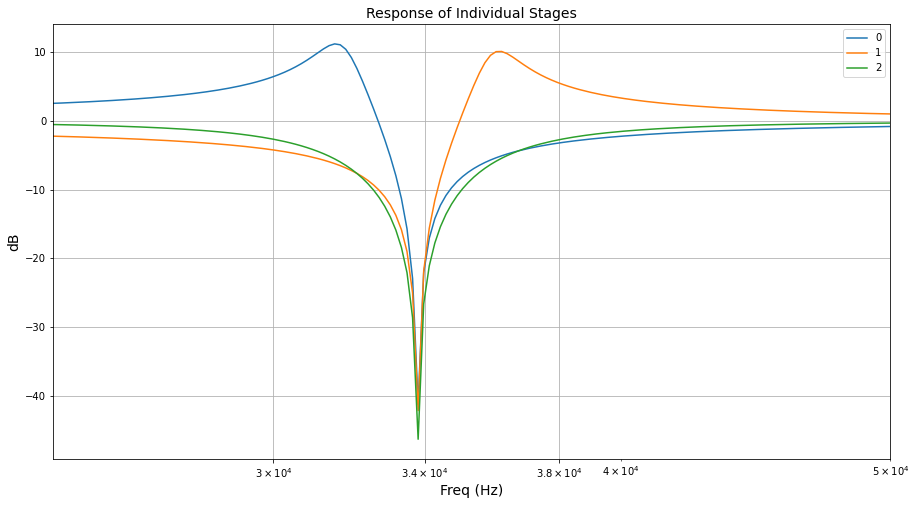

In [7]:
legend_index = []
numer = []
denom = []
plt.figure(figsize=(15,8))
### For each filter stage, compute the response. This method is preferred, as when debugging, 
### measured values of resistors and capacitors can be substituted for the calculated values 
### allowing the response to be compared and considered

for comps in StageComponents.iterrows():
    legend_index.append(comps[0])
    K1 = comps[1]['K1']
    K2 = comps[1]['K2']
    R2 = comps[1]['R2']
    R3 = comps[1]['R3']
    R4 = comps[1]['R4']
    R5 = comps[1]['R5 = R6']
    R6 = comps[1]['R5 = R6']
    C1 = comps[1]['C1']
    num = [K2,0,K2*K1/(R3*R5*C1*C2)]
    den = [1,(R5+R6)/(R5*R6*C2),K2/(R4*R5*C1*C2)]
    numer.append(num)
    denom.append(den)
    s1 = signal.TransferFunction(num, den)
    w1, mag1, phase1 = s1.bode(n=1000)
    plt.semilogx(w1/2/np.pi, mag1)
    
plt.grid(True)
plt.xlabel('Freq (Hz)',size=14)
plt.ylabel('dB',size=14)
plt.title('Response of Individual Stages',size=14)
plt.xlim([25000,50000])
plt.xticks(np.arange(30000, 40000, step=4000))  # Set label locations.
plt.legend(legend_index)

# 6. Convert each filter stage into a system and multiple together for response of full filter
The symbolic python library seemed to be best at handling this type of expansion

In [13]:
# Convert into system
def lti_to_sympy(lsys, symplify=True):
    #""" Convert Scipy's LTI instance to Sympy expression """
    s = sy.Symbol('s')
    G = sy.Poly(lsys.num, s) / sy.Poly(lsys.den, s)
    return sy.simplify(G) if symplify else G

h_sympy = []

for index,num in enumerate(numer):
    lti_H = signal.lti(num, denom[index])
    # convert to Sympy:
    h_sympy.append(lti_to_sympy(lti_H))

# I'll be honest, I'm using the lazy version to carry this out as I'll never use a filter order higher than 8th
if low_pass_filter_order == 1: 
    GHs = sy.simplify(h_sympy[0]).expand()
elif low_pass_filter_order == 2:    
    GHs = sy.simplify(h_sympy[0]*h_sympy[1]).expand()
elif low_pass_filter_order == 3:
    GHs = sy.simplify(h_sympy[0]*h_sympy[1]*h_sympy[2]).expand()    
elif low_pass_filter_order == 4:
    GHs = sy.simplify(h_sympy[0]*h_sympy[1]*h_sympy[2]*h_sympy[3]).expand()  
elif low_pass_filter_order == 5:
    GHs = sy.simplify(h_sympy[0]*h_sympy[1]*h_sympy[2]*h_sympy[3]*h_sympy[4]).expand()      
elif low_pass_filter_order == 6:
    GHs = sy.simplify(h_sympy[0]*h_sympy[1]*h_sympy[2]*h_sympy[3]*h_sympy[4]*h_sympy[5]).expand()     
elif low_pass_filter_order == 7:
    GHs = sy.simplify(h_sympy[0]*h_sympy[1]*h_sympy[2]*h_sympy[3]*h_sympy[4]*h_sympy[5]*h_sympy[6]).expand()         
elif low_pass_filter_order == 8:
    GHs = sy.simplify(h_sympy[0]*h_sympy[1]*h_sympy[2]*h_sympy[3]*h_sympy[4]*h_sympy[5]*h_sympy[6]*h_sympy[7]).expand()     
    
num, den = sy.simplify(GHs).as_numer_denom()  # expressions

numpoly = sy.poly(num, sy.Symbol('s'))
denpoly = sy.poly(den, sy.Symbol('s'))

numsys = np.array(numpoly.all_coeffs())
densys = np.array(denpoly.all_coeffs())

numsys = np.round(numsys.astype(float),2).tolist()
densys = np.round(densys.astype(float),2).tolist()

sys = signal.TransferFunction(numsys,densys)
display('Transfer Function')
display(GHs)


'Transfer Function'

1.0*s**6/(1.0*s**6 + 62927.6177922109*s**5 + 136812663795.757*s**4 + 5.71159646816741e+15*s**3 + 6.17048692121729e+21*s**2 + 1.28005186238381e+26*s + 9.17443676887072e+31) + 135305170223.766*s**4/(1.0*s**6 + 62927.6177922109*s**5 + 136812663795.757*s**4 + 5.71159646816741e+15*s**3 + 6.17048692121729e+21*s**2 + 1.28005186238381e+26*s + 9.17443676887072e+31) + 6.10249636309412e+21*s**2/(1.0*s**6 + 62927.6177922109*s**5 + 136812663795.757*s**4 + 5.71159646816741e+15*s**3 + 6.17048692121729e+21*s**2 + 1.28005186238381e+26*s + 9.17443676887072e+31) + 9.17443676887072e+31/(1.0*s**6 + 62927.6177922109*s**5 + 136812663795.757*s**4 + 5.71159646816741e+15*s**3 + 6.17048692121729e+21*s**2 + 1.28005186238381e+26*s + 9.17443676887072e+31)

([<matplotlib.axis.XTick at 0x229c34d1ac8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

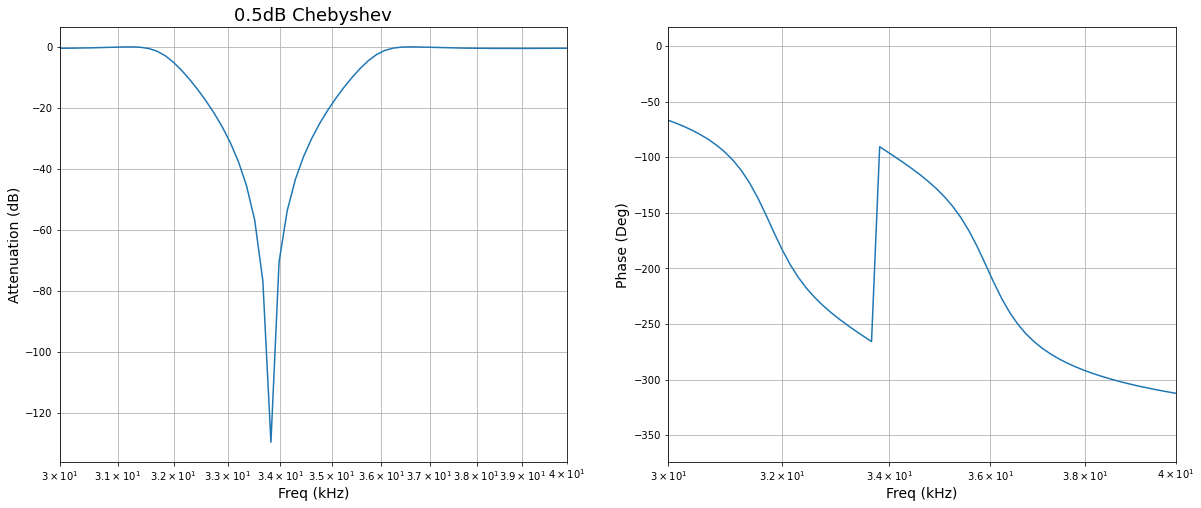

In [11]:
wsys, magsys, phasesys = sys.bode(n=1000)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.semilogx(wsys/2/np.pi/1000, magsys)    # Bode magnitude plot
plt.title(filtertype,size=18)
plt.xlim([30,40])
plt.grid(True)
plt.ylabel('Attenuation (dB)',size=14)
plt.xlabel('Freq (kHz)',size=14)
plt.xticks(np.arange(30, 40, step=1))  # Set label locations.

plt.subplot(1,2,2)
plt.semilogx(wsys/2/np.pi/1000, phasesys)  # Bode phase plot
plt.grid(True)
plt.xlim([30,40])
plt.ylabel('Phase (Deg)',size=14)
plt.xlabel('Freq (kHz)',size=14)

#Add additional grid lines (ticks) in local area of interest
plt.xticks(np.arange(30, 40, step=2))  # Set label locations.


# 7. Find magnitude of interferring frequencies of interest, and display all values of interest as a summary
For explanatory purposes, choose frequency and determine how much attenuation might be present. Can be used in absolute terms if magnitude of interference is used, and then converted to determine how much is remaining.

In [10]:
Avg_Freq = 33

Index_Closest_Freq_Avg = np.abs(wsys/2/np.pi/1000 - Avg_Freq).argmin()
print(magsys[Index_Closest_Freq_Avg],' dB of attenuation at',Avg_Freq,'kHz')



-31.39849649979488  dB of attenuation at 33 kHz
